## Visualization of CNN: Grad-CAM

Explainability and interpretability of predictions is one of the most pressing issues in DeepLearning today as it is crucial to the acceptance of and trust in DeepLearning systems by humans. This is especially true when applied to sensitive fields touching privacy and health issues.


GradCam provides an approach of interpreting or explaining the predictions by highlighting areas of the input where small changes would have a larger influence on the prediction. Thus we might interpret these areas as those that were important to the network for its prediction. This can allow us judging not only the prediction but also its motivation.

In this notebook we implemented GradCam and tested it on 20 images with the VGG16 network trained on the ImageNet dataset. We can observe that in most cases the generated heatmap coincides with what a human would label as the area of interest. It is furthermore interesting that high class scores seem to correlate with a good heatmap (i.e. focusing on the correct image area). It is now possible to say e.g. the red_fox was correctly classified for a correct reason, whereas the old_english_sheepdog might have been correctly classified but not for such a good reason (its heatmap only focused on the dogs foot). All in all the heatmaps of the tested examples look very reasonable and we could say vgg16 on the ImageNet produces good predictions along with good explanations.

It will be interesting to see further efforts (maybe based on GradCam) to automatically generate convincing arguments for the networks predictions.

In [9]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image

%matplotlib inline

### Download the Model
Use a pretrained model `VGG-16` for `ImageNet` classification dataset.

![vgg_16.png](https://www.researchgate.net/profile/Bibo_Shi/publication/323440752/figure/fig1/AS:739814685032448@1553396974148/The-architecture-of-VGG-16-model-To-represent-different-depth-levels-convolutional.jpg)

In [10]:
# The downloading process may take a few minutes. 
vgg_model = models.vgg16(pretrained=True)# return the vgg-16 model pretrained on ImageNet dataset.

### Input Images

In [3]:
# Define preprocessing function of the input images
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [4]:
dir_path = "data/" 
dataset = preprocess_image(dir_path)

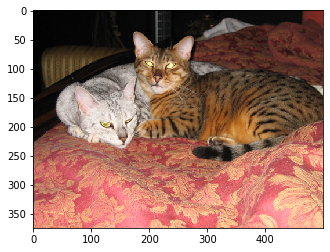

In [5]:
# show the orignal image 
index = 5
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

Predict the label of the input image, and print the top-3 possible classes

In [6]:
output = vgg_model(dataset[index][0].view(1, 3, 224, 224))

values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy())
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [285 281 282]
Raw class scores: [16.88148  16.796215 15.781341]


### Grad-CAM 

In [7]:
import torch.nn.functional as F
from torch.autograd import grad

class Grad_CAM():
    def __init__(self, model):
        self.model = model
        self.activations = None
        self.gradient = None
        
        # register hooks to capture the feature_map gradients
        def forward_hook(model, input, output):
            self.activations = output[0]
        def backward_hook(model, grad_input, grad_output):
            self.gradient = grad_output[0][0]
            
        feat_map = model.features[29]
        feat_map.register_forward_hook(forward_hook)
        feat_map.register_backward_hook(backward_hook)
        
    def get_grad_cam(self, img):
        out = self.model(img)
        num_features = self.activations.size()[0]
        topk = 3
        values, indices = torch.topk(out, topk)
        # Compute 14x14 heatmaps
        heatmaps = torch.zeros(topk,14,14)
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        for i,c in enumerate(indices[0]):
            self.model.zero_grad()
            out[0,c].backward(retain_graph=True)
            # feature importance
            feature_importance = self.gradient.mean(dim=[1,2])
            # pixel importance
            for f in range(num_features):
                heatmaps[i] += feature_importance[f] * self.activations[f]
            heatmaps[i] = F.relu(heatmaps[i])
        
        # Upsample to 224x224
        large_heatmaps = F.interpolate(heatmaps.expand((1,topk,14,14)), (224,224), mode='bilinear')
        return large_heatmaps[0].data.numpy(), values.data.numpy()[0], indices.data.numpy()[0]

### Visualization routine

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications.imagenet_utils import decode_predictions

def get_titles(values, indices):
    predictions = np.zeros((1,1000))
    predictions[0,indices] = values
    decoded = decode_predictions(predictions, top=3)
    return [decoded[0][0][1],decoded[0][1][1],decoded[0][2][1]]

def plot_heatmaps(img, heatmaps, values = None, indices = None):
    fig, axs = plt.subplots(figsize=(18, 5), ncols=3)
    for k in range(3):
        ax = axs[k]
        ax.imshow(img)
        h = ax.imshow(heatmaps[k], cmap='jet', alpha=0.4)        
        title = 'Top '+str(k+1)
        if values is not None and indices is not None:
            title += '\nclass '+str(indices[k])
            title += '    score '+str(np.round(values[k],2))
        ax.set_title(title, fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
        cbar = fig.colorbar(h, ax=ax, )
        cbar.ax.tick_params(labelsize=14)
    fig.tight_layout()
    
    titles = get_titles(values, indices)
    suptitle = 'Top 1: '+titles[0]+'\nTop 2: '+titles[1]+'\nTop 3: '+titles[2]
    fig.suptitle(suptitle, x=0, y=1.2, fontsize=20, ha='left', va='top')
    return fig

rgb_dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor()]))

### Compute heatmaps for all images


  0%|          | 0/20 [00:00<?, ?it/s]/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()

100%|██████████| 20/20 [02:21<00:00,  7.05s/it]


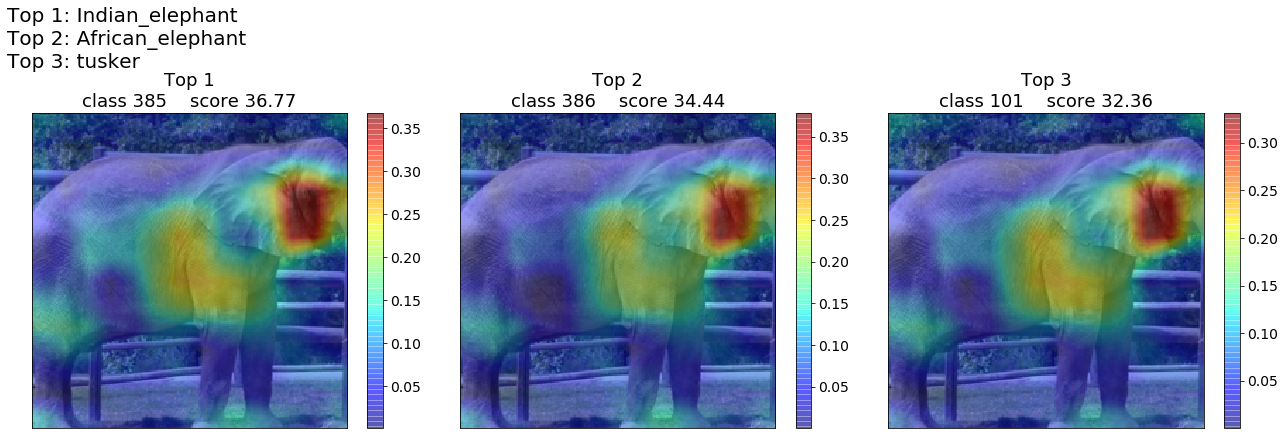

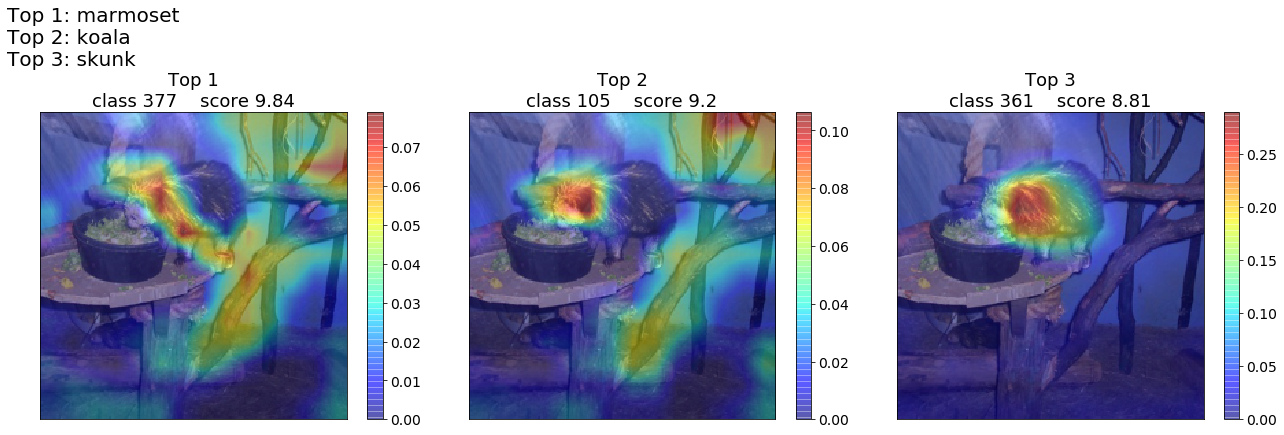

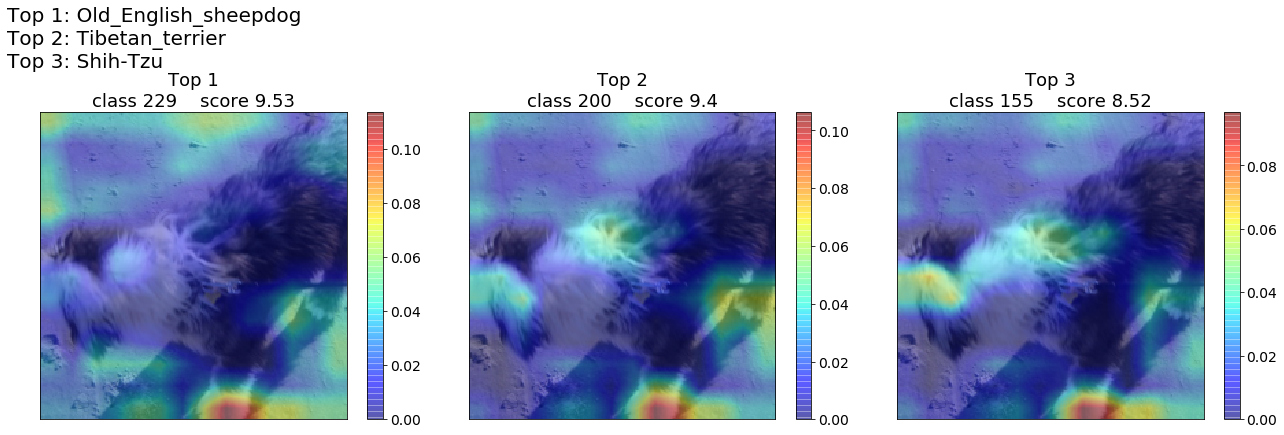

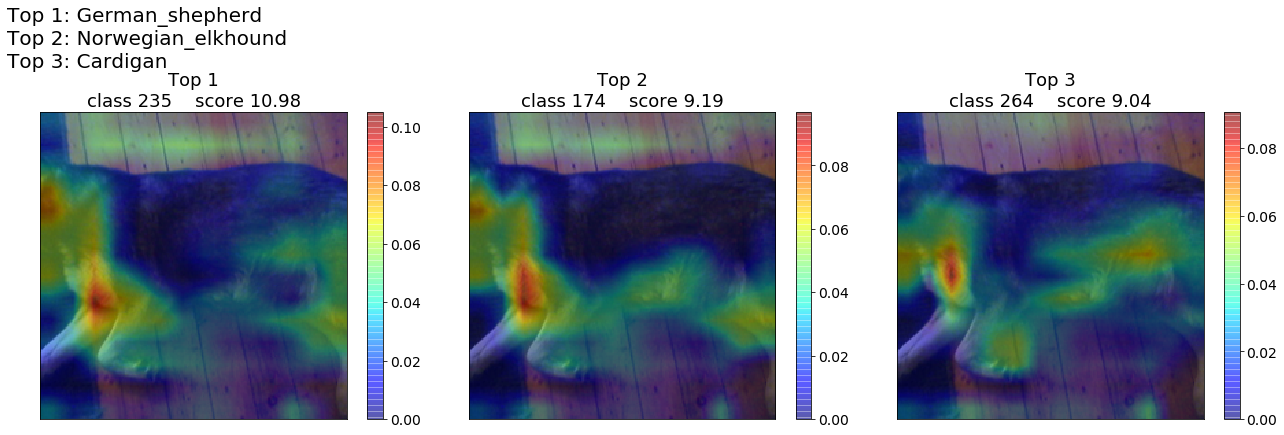

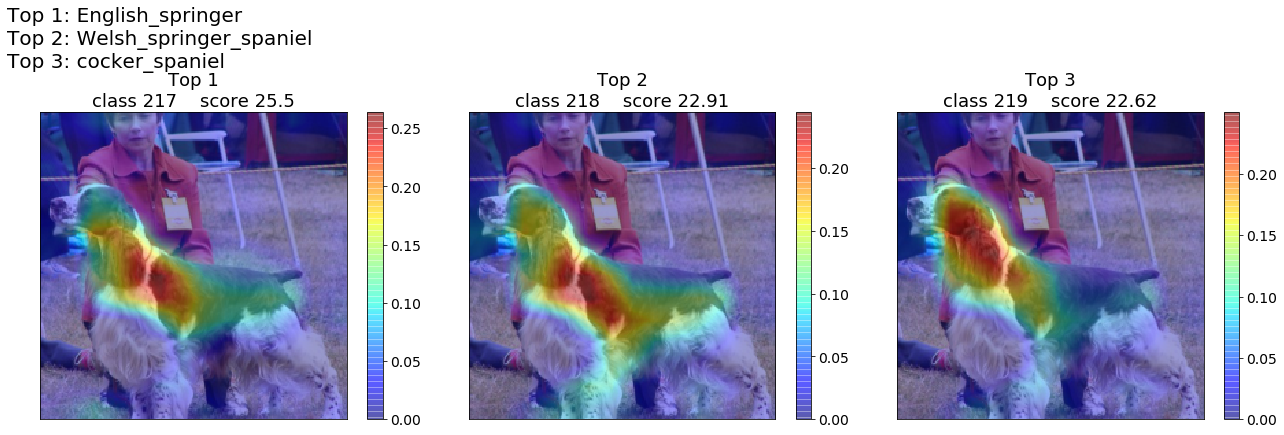

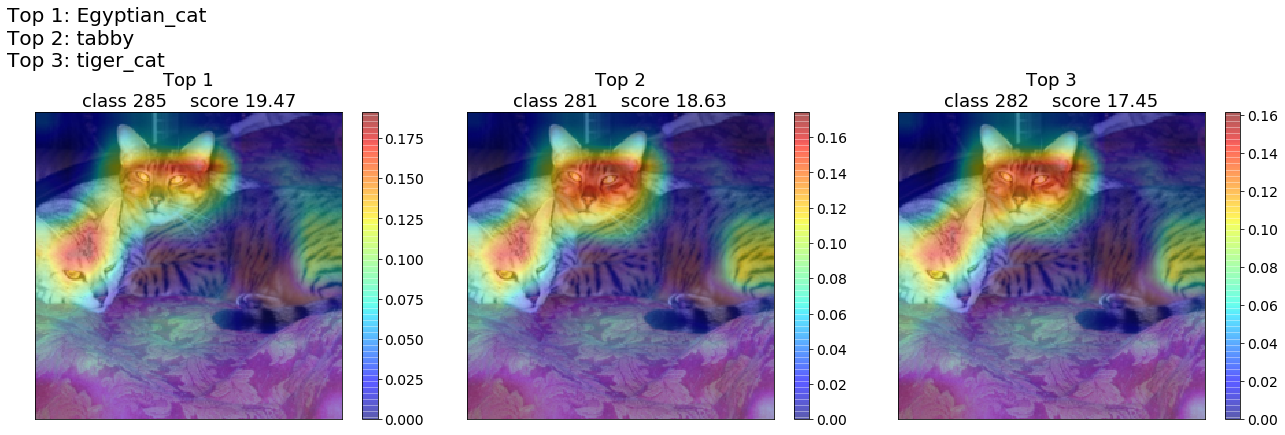

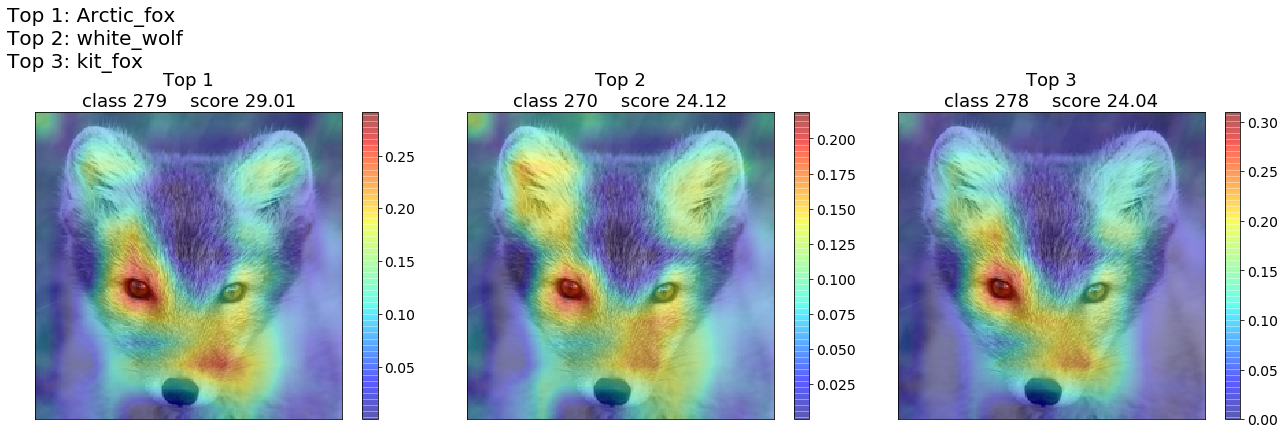

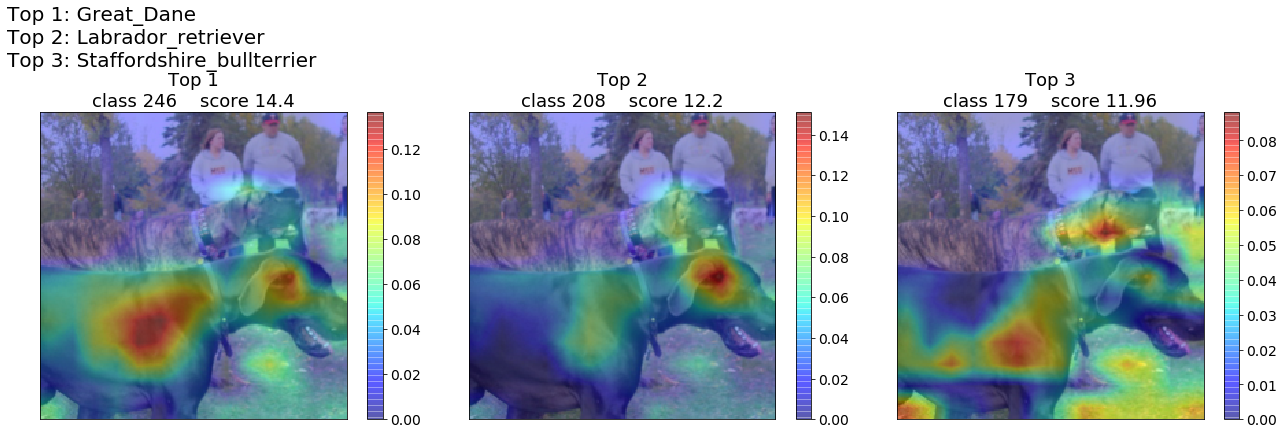

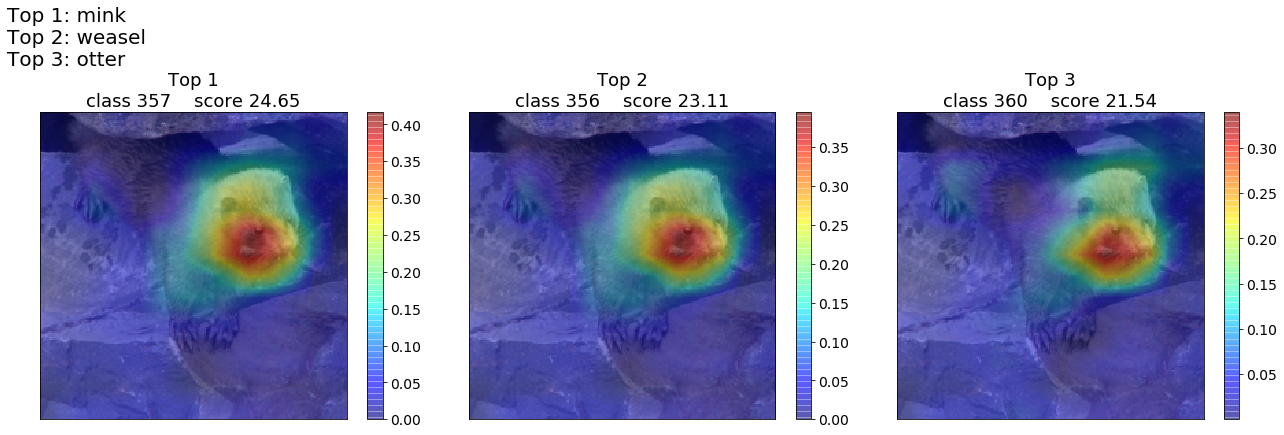

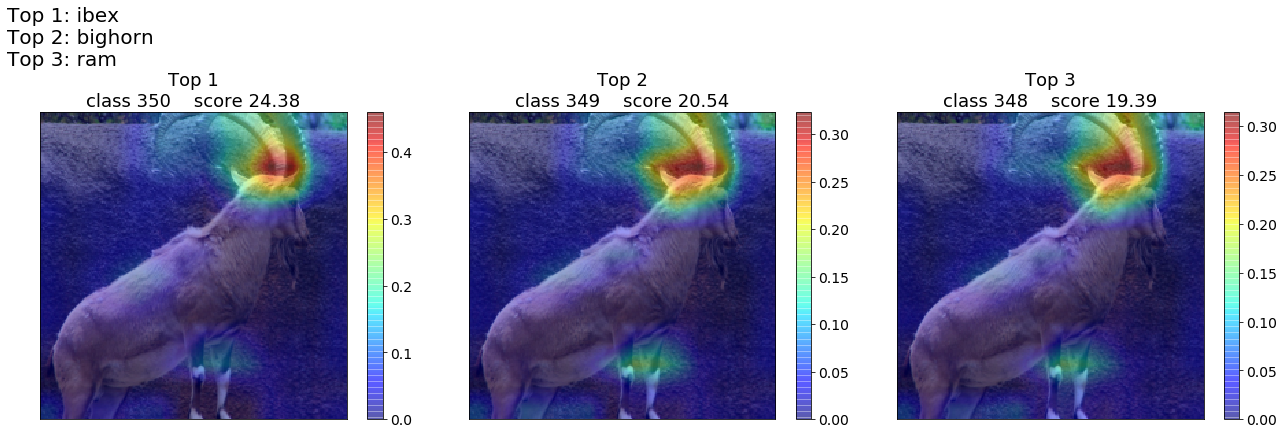

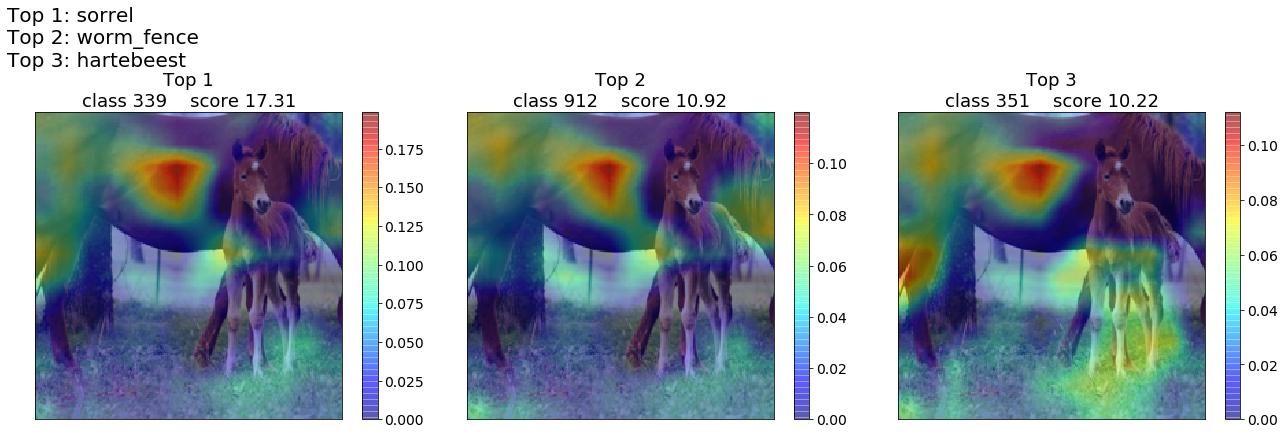

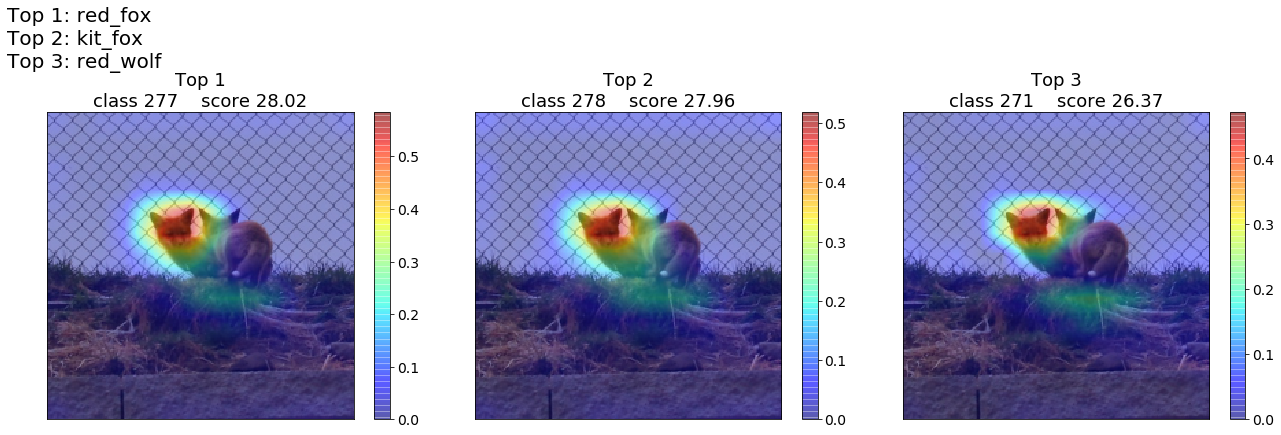

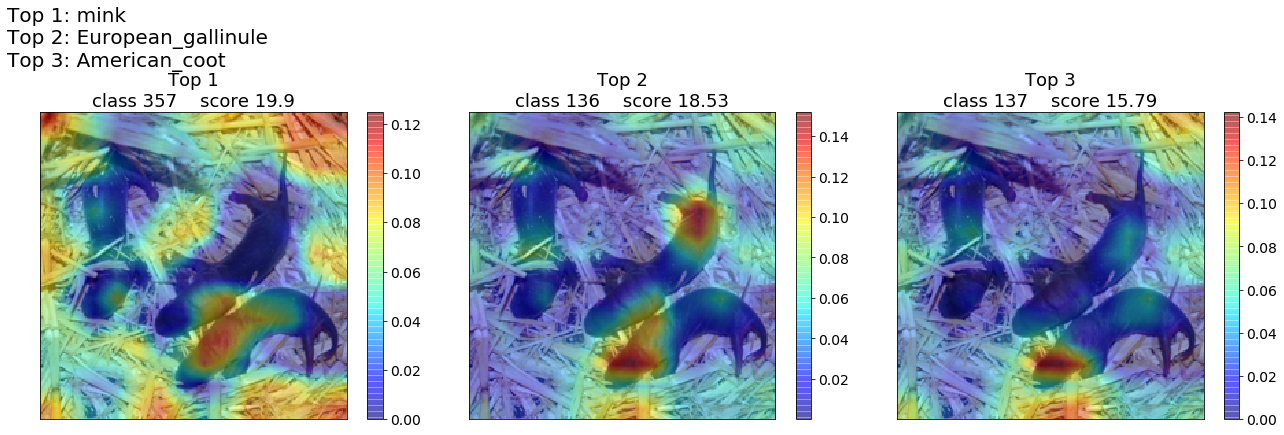

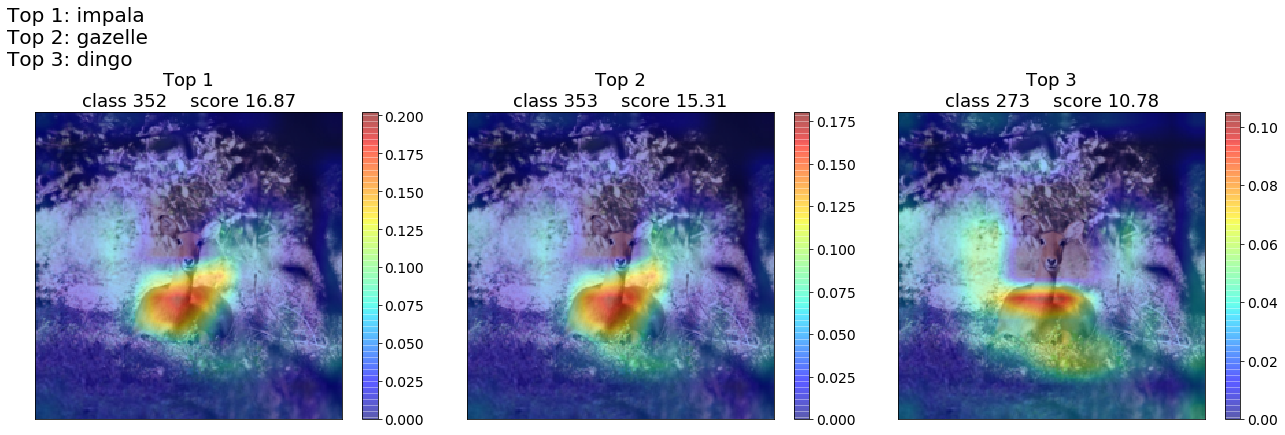

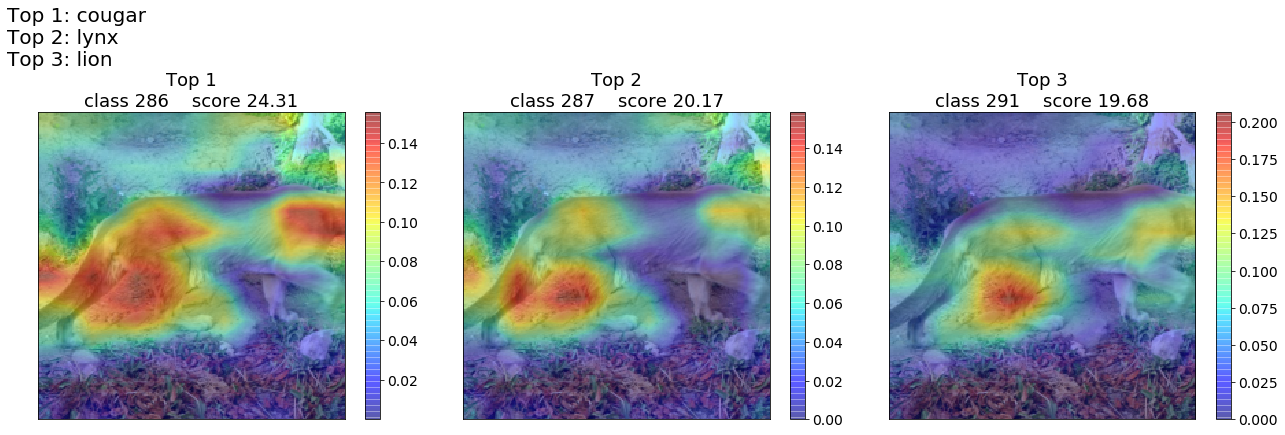

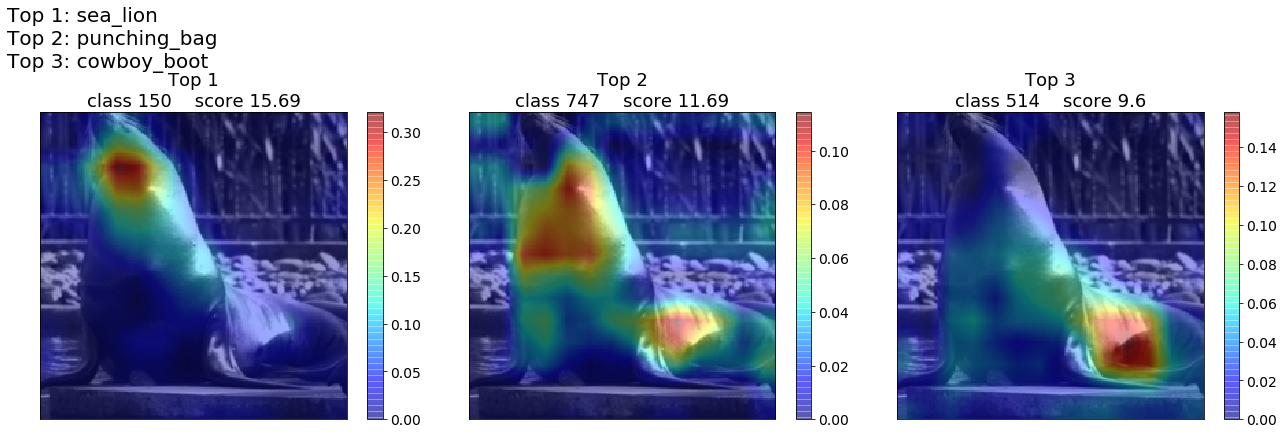

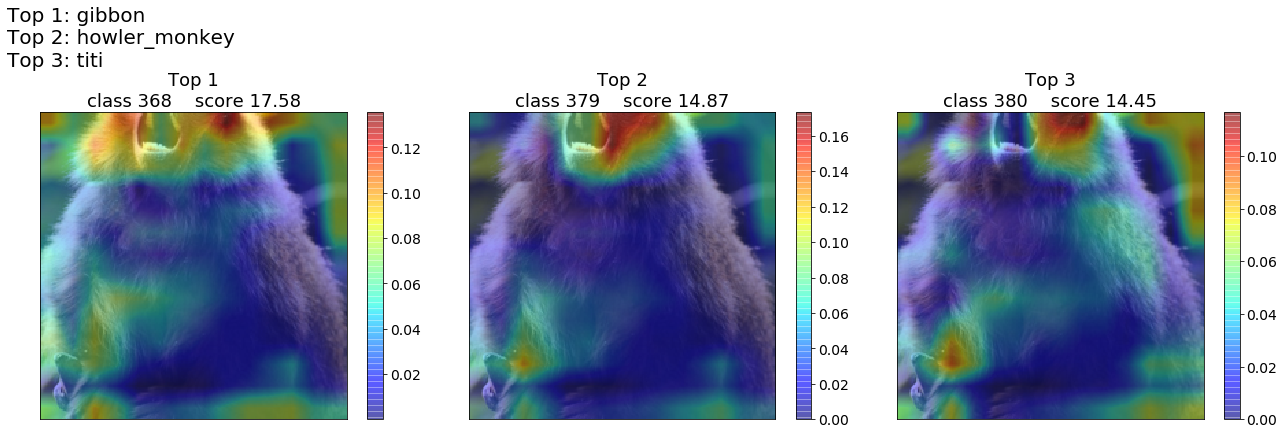

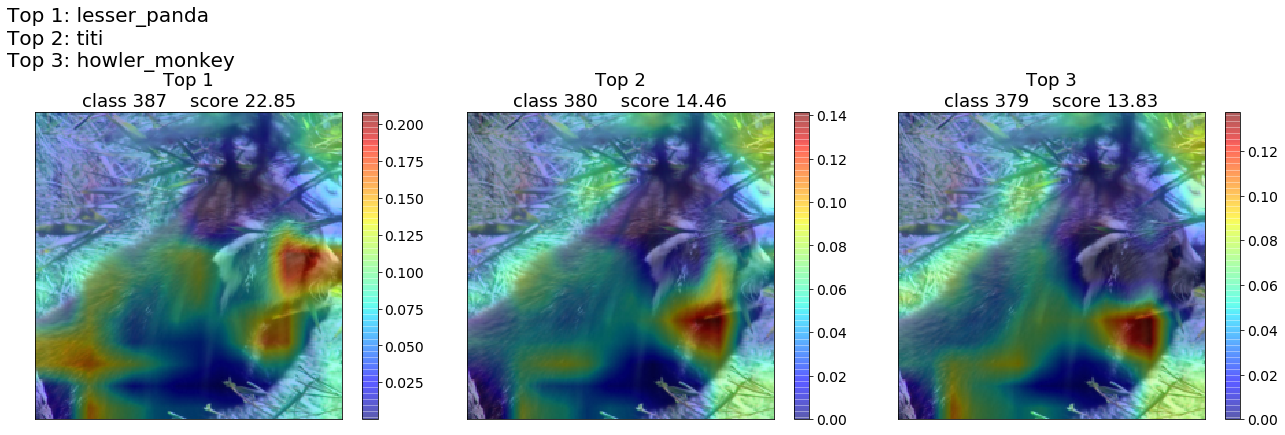

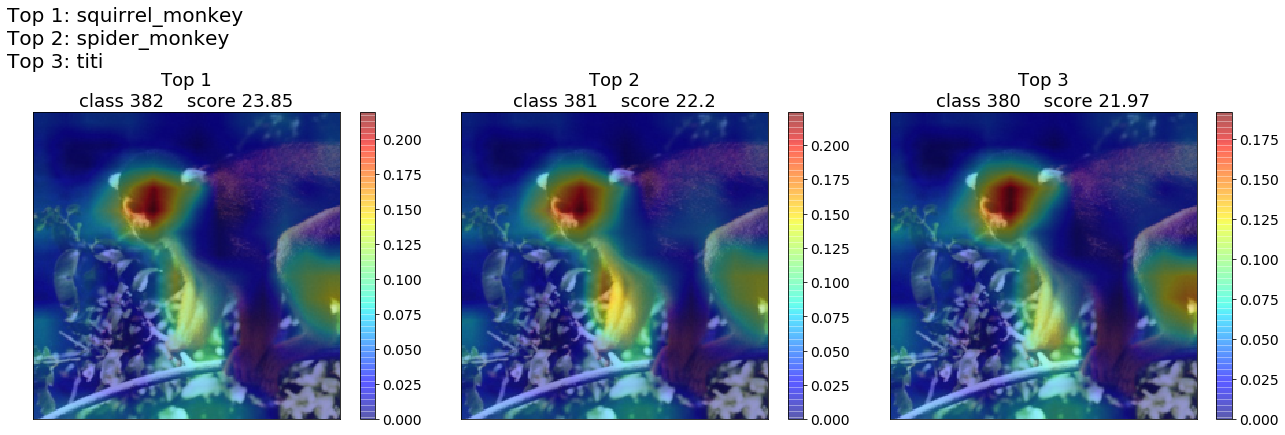

In [14]:
from tqdm import tqdm 
# Construct a Grad_CAM
cam = Grad_CAM(vgg_model)

for index in tqdm(range(len(dataset))):
    # read an image
    img = dataset[index][0].view(1, 3, 224, 224)
    dataset[index][0].view(1, 3, 224, 224)
    
    # Compute the gradients & heatmaps
    heatmaps, values, indices = cam.get_grad_cam(img)

    # Visualize the heatmaps
    rgb_img = np.transpose(rgb_dataset[index][0].view(1, 3, 224, 224).numpy()[0], [1,2,0])
    fig = plot_heatmaps(rgb_img, heatmaps, values, indices)
    fig.show()